# Dependencies and globals

In [7]:
PROJECT_ID = ""
LOCATION = "us-central1"
LLM_MODEL_NAME = "gemini-1.5-pro-001"

In [2]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 26.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


# 1. Get bounding boxes from the LLM


In [3]:
import base64
import vertexai
from vertexai.preview.generative_models import GenerativeModel, Part, Image
import vertexai.preview.generative_models as generative_models
import pandas as pd
import json

In [8]:
def generate(prompt):
    txt_response = ""
    vertexai.init(project = PROJECT_ID, location = LOCATION)
    model = GenerativeModel( LLM_MODEL_NAME )
    responses = model.generate_content(
        prompt,
        generation_config={
            "max_output_tokens": 2048,
            "temperature": 0.4,
            "top_p": 1,
            "top_k": 32
        },
        safety_settings={
              generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
              generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
              generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
              generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        },
        stream=True,
    )

    for response in responses:
        txt_response += response.text
    
    return txt_response

In [31]:
image = Part.from_image(Image.load_from_file("Gondola-10.jpg")) 
prompt = ["""This is a public photo of a shelve in Jumbo store in Chile. """,
    """Create bounding boxes of all the products you see. """,
    """Rules for the bounding boxes: 
          - The scale of the bounding boxes coordinates should be in pixels, corresponding with the size of the image provided. 
          - No coordinate on the x or y axis could be outside from the original image size. This is a must 
          - x+width on any bounding box should never be larger than the image width.
          - y+height on any bounding box should never be larger than the image height.
          - There could several items of the same product, create a bounding box for each one.""",
    """Rules of how to generate bounding boxes:
        - Identify bounding boxes where there actual products.
        - Based on how the shelve is organized, predict where should be products that are missing.""",
    """Rules of how to label product names:
        - Assign a different product name to each different product.
        - There could several items of the same product, identify all similar items with the same product_name on the table.
        - I should be able to identify with the output list, which bounding boxes correspond to products with out of stock""",          
     image, 
     """Rules for the output:
         - Format it as a csv comma separated table.
         - Use the headers headers: product_name, x, y, width, heigh, stock.
         - Definition of each field:""",
     """     * product_name. picture that correspond to the same product presentation.""", 
     """     * x: X point of starting point of the bounding box""", 
     """     * y: Y point of the starting point of the bounding box""", 
     """     * width: Width of bounding box""", 
     """     * heigh: Height of coordinate of bounding box""", 
     """     * stock: wheter there are products or not on the shelve. true or false"""]

In [ ]:
text_generated_json = generate(prompt)
text_generated_json

In [34]:
import csv
rows = text_generated_json.splitlines()
reader = csv.DictReader(rows)
data_dict = list(reader)
df = pd.DataFrame.from_dict(data_dict)
df

,product_name,x,y,width,heigh,stock
0,product_1,142,55,61,121,true
1,product_1,76,56,66,121,true
2,product_2,199,55,61,120,true
3,product_3,258,56,60,120,true
4,product_4,317,57,61,119,true
...,...,...,...,...,...,...
90,product_56,139,190,61,121,true
91,product_57,199,190,61,121,true
92,product_58,259,190,61,121,true
93,product_59,319,190,61,121,true


# 2. Draw bounding boxes

In [35]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [36]:
def draw_bounding_boxes(image_path, coordinates, labels=None, colors=None):
    """
    Draws bounding boxes on an image.

    Args:
        image_path (str): The path to the image file.
        coordinates (list): A list of bounding box coordinates in the format [(x, y, width, height), ...].
        labels (list, optional): A list of labels corresponding to each bounding box. Defaults to None.
        colors (list, optional): A list of colors (e.g., 'red', 'green') for each bounding box. 
                                 Defaults to a generated list of distinct colors.
    """

    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # If colors are not provided, generate a list of distinct colors
    if colors is None:
        colors = plt.cm.get_cmap('tab10', len(coordinates)).colors

    # Create a Matplotlib figure for a cleaner display
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 

    # Draw each bounding box
    for i, (x, y, width, height) in enumerate(coordinates):
        # Create a Rectangle patch
        rect = mpatches.Rectangle((x, y), width, height, 
                                  linewidth=2, edgecolor=colors[i], facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add label if provided
        if labels:
            plt.text(x, y - 10, labels[i], color='white', fontsize=10, bbox=dict(facecolor=colors[i], alpha=0.5))

    plt.show()

In [37]:
coordinates = []
for coordinate in data_dict:
    coordinates.append((
        int(coordinate["x"])/3, 
        int(coordinate["y"])/3, 
        int(coordinate["width"])/3,
        int(coordinate["heigh"])/3
    ))
coordinates[:3]

[(47.333333333333336,
  18.333333333333332,
  20.333333333333332,
  40.333333333333336),
 (25.333333333333332, 18.666666666666668, 22.0, 40.333333333333336),
 (66.33333333333333, 18.333333333333332, 20.333333333333332, 40.0)]

/var/tmp/ipykernel_341078/649358133.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(coordinates)).colors


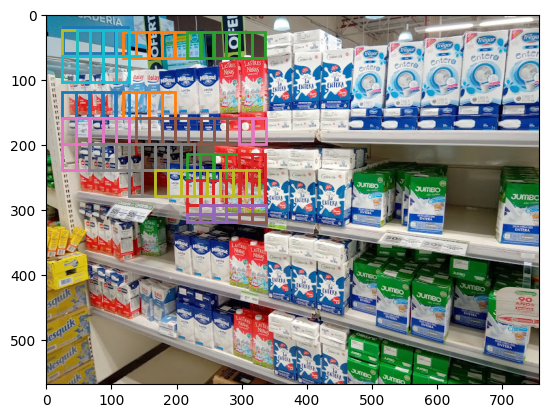

In [38]:
# Example usage:
image_path = 'Gondola-10.jpg'

#labels = ['Object 1', 'Object 2']  # Optional
#colors = ['blue', 'orange']  # Optional

draw_bounding_boxes(image_path = image_path, coordinates = coordinates, labels = None, colors = None)